In [62]:
# load libraries
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
import pdb

# For plotting
import matplotlib.pyplot as plt

# for statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


# #uncertainties packages
# from uncertainties import ufloat
# from uncertainties.umath import *  #e.g. sqrt()
# from uncertainties import unumpy

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML
# uncomment this line and run the cell --> fit the cells to screen. Comment and re-run to disable full width.
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('seaborn-darkgrid')


In [63]:
## probably not usable class_id: 26, 56
## input
data_path = "../data"
input_path = f"{data_path}/experiment-result-2021-06-15.csv"
input_path_uncomp = f"{data_path}/experiment-uncomp-06-14-2021.csv"
visual_metric = "MOTA"
averaged_result_class = "all"

In [64]:
df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
df_all.reset_index(inplace=True, drop=True)
df_all

,class_cat,seq_name,class_id,QP,MSR,IDTP,IDFP,IDFN,IDF1,IDP,IDR,Recall,Precision,F1,GT,MT,PT,ML,TP,FP,FN,IDs,FM,mAP-50,MOTA,MOTP
0,ClassB,BasketballDrive,all,0,0,1358.00,1997.00,2987.00,35.30,40.50,31.30,67.10,87.10,75.80,17,5,9,3,2917,431,1428,83,103,58.13,55.30,81.30
1,ClassB,Cactus,all,0,0,120.00,232.00,380.00,28.20,34.10,24.00,60.20,85.50,70.65,1,0,1,0,301,51,199,7,11,67.96,48.60,88.20
2,ClassB,Kimono,all,0,0,140.00,95.00,222.00,46.90,59.60,38.70,64.90,100.00,78.71,2,1,0,1,235,0,127,1,1,51.14,64.60,85.70
3,ClassB,ParkScene,all,0,0,631.00,181.00,870.00,54.80,77.70,42.00,52.80,98.60,68.77,10,5,2,3,792,11,709,15,26,71.93,51.00,82.10
4,ClassC,BasketballDrill,all,0,0,824.00,1521.00,4201.00,22.40,35.10,16.40,43.50,93.50,59.38,11,3,4,4,2186,153,2839,56,78,41.79,39.30,79.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,ClassE,KristenAndSara,all,42,64,2675.00,1210.00,6332.00,41.50,68.90,29.70,31.50,72.90,43.99,17,4,1,12,2833,1052,6174,3,17,41.95,19.70,75.10
392,ClassE,KristenAndSara,all,46,8,1595.00,770.00,7412.00,28.10,67.40,17.70,22.00,83.80,34.85,17,3,1,13,1982,383,7025,9,15,37.95,17.70,79.60
393,ClassE,KristenAndSara,all,46,16,1888.00,506.00,7119.00,33.10,78.90,21.00,22.90,86.30,36.20,17,3,1,13,2065,329,6942,5,20,39.29,19.20,78.40
394,ClassE,KristenAndSara,all,46,32,1543.00,894.00,7464.00,27.00,63.30,17.10,21.50,79.40,33.84,17,3,1,13,1935,502,7072,15,25,36.09,15.70,80.30


In [65]:
# from statsmodels.stats.weightstats import ttest_ind
import scipy

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
df_all.reset_index(inplace=True, drop=True)
df_all['QP_transform'] = 1 / (df_all['QP'] / 52 - 1)

df_all['QP_transform*MSR'] = df_all['QP_transform'] * df_all['MSR']

qp_list = [18, 22, 26, 30, 34, 38, 42, 46]

# take the difference between compressed and uncompressed
df_all_diff = df_all.copy()
for metric in df_all_diff:
    if metric == 'GT' or metric == "class_cat" or metric == "seq_name" or metric=="class_id" or metric == "QP" or metric == "QP_transform" or metric == "MSR" or metric == "QP_transform*MSR":
        continue

    for i in df_all.index:
    #     ind = (df_all['class_cat'] == df_all.loc[i, 'class_cat']) &  (df_all['seq_name'] == df_all.loc[i, 'seq_name']) & (df_all['QP'] == 0)
        class_cat = df_all.loc[i, 'class_cat']
        seq_name = df_all.loc[i, 'seq_name']
        uncomp_val = float(df_all.query(f'class_cat == "{class_cat}" and seq_name == "{seq_name}" and QP == 0')[metric])
        
        if metric == "IDFN" or metric == "FN" or metric == "ML" or metric == "PT":
            df_all_diff.loc[i, metric] =  df_all.loc[i, metric] - uncomp_val
        else:
            df_all_diff.loc[i, metric] = uncomp_val - df_all.loc[i, metric]

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
df_stats = pd.DataFrame([])
header = ['QP', 'QP_transform', 'MSR', 'QP_transform*MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']
metric_list = ['IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']
df_all_avg = df_all_diff.query('QP > 0')[header]
for metric in metric_list:
    if metric == "MOTA": # do only for MOTA
#     if True: # do all metrics not only MOTA

        # r-style method
        #result = smf.ols(formula=f"{metric} ~ QP_transform + MSR + QP_transform * MSR", data=df_all_avg).fit()

        # OLS method
    #         y = df_all_avg[metric]
    #         X = df_all_avg[['QP_transform', 'MSR', 'QP_transform*MSR']]
    #         X = sm.add_constant(X)
    #         result = sm.OLS(y, X).fit()

        # WLS method
        y = df_all_avg[metric]
        X = df_all_avg[['QP_transform', 'MSR', 'QP_transform*MSR']]
        X = sm.add_constant(X)

        # compute the weight w for the specific metric
        qp_transform_list = list(set(df_all_avg['QP_transform']))
        for qp_transform in qp_transform_list:
            # computing the weight w = 1 / (sample variance at each QP_transform)
            w_at_qp_transform = 1 / np.var(df_all_avg.query(f'QP_transform == {qp_transform}')[metric], ddof=1)
            df_all_avg.loc[(df_all_avg['QP_transform'] == qp_transform), 'w'] = w_at_qp_transform
        w = df_all_avg['w']
    #         w = np.ones(len(y)) # 1 .. same as OLS
        result = sm.WLS(y, X, w).fit()
        
        series = result.params
        series['p-value(Intercept)'] =  result.pvalues[0]
        series['p-value(QP)'] =  result.pvalues[1]
        series['p-value(MSR)'] =  result.pvalues[2]
        series['p-value(QP*MSR)'] =  result.pvalues[3]
    #         series['rsquared'] = result.rsquared
        rvalue = result.rsquared
        df_stats[metric] = series
        df_stats.fillna(1.0, inplace=True)

df_stats.index = ['parameter(Intercept)', 'parameter(QP\')', 'parameter(MSR)', 'parameter(QP\'*MSR)',
                  'p-value(Intercept)', 'p-value(QP\')', 'p-value(MSR)', 'p-value(QP\'*MSR)']

# df_stats.index = ['$\\beta_0$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$',
#                   'p-value($\\beta_0$)', 'p-value($\\beta_1$)', 'p-value($\\beta_2$)', 'p-value($\\beta_3$)']


display(df_stats)
# print(df_stats.to_latex(index=True, multirow=True, escape=False, multicolumn_format='c'))
print(w)
print(rvalue)

,MOTA
parameter(Intercept),-4.32
parameter(QP'),-2.97
parameter(MSR),-0.01
parameter(QP'*MSR),-0.00
p-value(Intercept),0.00
p-value(QP'),0.00
p-value(MSR),0.83
p-value(QP'*MSR),0.77


12    0.36
13    0.36
14    0.36
15    0.36
16    0.13
      ... 
391   0.01
392   0.00
393   0.00
394   0.00
395   0.00
Name: w, Length: 384, dtype: float64
0.2554213391849538


,QP,QP_transform,MSR,MOTA,MOTA_fit,w_MOTA
0,18,-1.53,8,0.10,0.22,0.36
1,18,-1.53,16,0.00,0.22,0.36
2,18,-1.53,32,-0.50,0.23,0.36
3,18,-1.53,64,-0.20,0.24,0.36
4,22,-1.73,8,0.10,0.83,0.13
...,...,...,...,...,...,...
379,42,-5.20,64,-6.20,12.00,0.01
380,46,-8.67,8,-4.20,21.64,0.00
381,46,-8.67,16,-5.70,21.85,0.00
382,46,-8.67,32,-2.20,22.27,0.00


beta0 =  -4.324457111342321
beta1 =  -2.9715170219555516
beta2 =  -0.0053172936528347176
beta3 =  -0.003649878354063843
At i = 0, MOTA_fit =  23.11284947887844


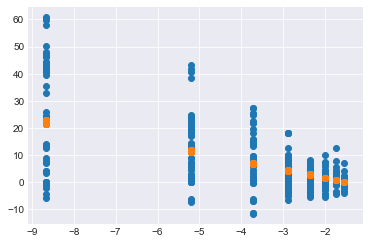

In [67]:
metric = "MOTA"

df_all_avg = df_all_avg.reset_index(drop=True)

# get y_fit
beta0 = df_stats.loc['parameter(Intercept)', metric]
beta1 = df_stats.loc['parameter(QP\')', metric]
beta2 = df_stats.loc['parameter(MSR)', metric]
beta3 = df_stats.loc['parameter(QP\'*MSR)', metric]
y_fit = beta0 + beta1 * df_all_avg['QP_transform'] + beta2 * df_all_avg['MSR'] + beta3 * df_all_avg['QP_transform'] * df_all_avg['MSR']

# get w
qp_transform_list = list(set(df_all_avg['QP_transform']))
for qp_transform in qp_transform_list:
    # computing the weight w = 1 / (sample variance at each QP_transform)
    w_at_qp_transform = 1 / np.var(df_all_avg.query(f'QP_transform == {qp_transform}')[metric], ddof=1)
    df_all_avg.loc[(df_all_avg['QP_transform'] == qp_transform), 'w_MOTA'] = w_at_qp_transform
df_all_avg['MOTA_fit'] = y_fit

display(df_all_avg[['QP', 'QP_transform', 'MSR','MOTA', 'MOTA_fit', 'w_MOTA']].reset_index(drop=True))
w = df_all_avg['w_MOTA']
print('beta0 = ', beta0)
print('beta1 = ', beta1)
print('beta2 = ', beta2)
print('beta3 = ', beta3)

i = 383
print("At i = 0, MOTA_fit = ", beta0 + beta1 * df_all_avg.loc[i, 'QP_transform'] + beta2 * df_all_avg.loc[i, 'MSR'] + beta3 *  df_all_avg.loc[i, 'QP_transform'] *  df_all_avg.loc[i, 'MSR'])

plt.scatter(df_all_avg['QP_transform'], df_all_avg['MOTA'])
plt.scatter(df_all_avg['QP_transform'], df_all_avg['MOTA_fit'])

## Sorted studentized Residual vs Expected value of studentized residual under normality

MSE_sqrt =  1.0089786094290483
[0.00405691 1.00115438]
0.9851783725547589


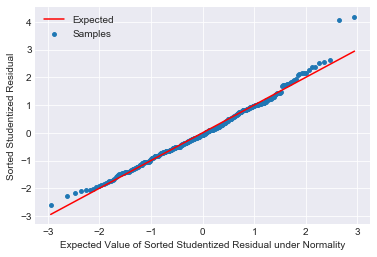

In [68]:
import scipy

# summarize
w = df_all_avg['w_MOTA']
y = df_all_avg['MOTA']
y_fit = df_all_avg['MOTA_fit']

w = np.array(w)
y = np.array(y)
y_fit = np.array(y_fit)

# calculate the weighted MSE
MSE = 0
for i in range(len(y)):
    MSE += w[i] * ( y[i] - y_fit[i] ) ** 2 / (len(y) - 4)
MSE_sqrt = np.sqrt(MSE)
print("MSE_sqrt = ", MSE_sqrt)

sorted_std_res = np.sort( (y-y_fit) * np.sqrt(w))
z = scipy.stats.norm.ppf( (np.arange(1,385) - 0.375) / (len(y) + 0.25)  )

plt.scatter(z, sorted_std_res, s=15, label='Samples')
plt.plot(z,z, c='r', label='Expected')
plt.xlabel('Expected Value of Sorted Studentized Residual under Normality')
plt.ylabel('Sorted Studentized Residual')
plt.legend()
y = sorted_std_res
X = z
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.params)
print(result.rsquared)
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/normal_probability_plot.pdf", bbox_inches="tight")

((array([-2.9106407 , -2.62148742, -2.45834023, -2.34237456, -2.25132656,
         -2.17582633, -2.11100786, -2.0540069 , -2.00298954, -1.95670809,
         -1.91427376, -1.87503017, -1.83847827, -1.80422943, -1.77197483,
         -1.74146489, -1.71249486, -1.68489466, -1.65852133, -1.63325359,
         -1.60898757, -1.58563361, -1.56311378, -1.54135988, -1.52031188,
         -1.49991664, -1.4801269 , -1.46090042, -1.4421993 , -1.42398938,
         -1.40623978, -1.38892249, -1.37201198, -1.35548496, -1.33932011,
         -1.32349785, -1.30800015, -1.29281039, -1.2779132 , -1.26329434,
         -1.24894058, -1.23483963, -1.22098002, -1.20735107, -1.19394276,
         -1.18074574, -1.16775121, -1.15495093, -1.14233714, -1.12990254,
         -1.11764022, -1.1055437 , -1.09360682, -1.08182377, -1.07018903,
         -1.05869738, -1.04734388, -1.03612379, -1.02503265, -1.01406619,
         -1.00322035, -0.99249125, -0.98187521, -0.97136868, -0.9609683 ,
         -0.95067084, -0.94047322, -0.

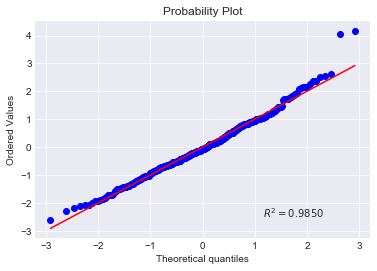

In [69]:
from scipy.stats import probplot
# summarize
w = df_all_avg['w_MOTA']
y = df_all_avg['MOTA']
y_fit = df_all_avg['MOTA_fit']
w = np.array(w)
y = np.array(y)
y_fit = np.array(y_fit)
probplot( (y-y_fit) *  np.sqrt(w), dist='norm', plot=plt, rvalue=0.2612833844046678) # rvalue is from weighted least square